In [3]:
import math
import re
import numpy as np
import pandas as pd

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import spacy
nlp = spacy.load("en_core_web_lg")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angela/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/angela/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/angela/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
cd ..

/Users/angela/diversity-colleges


In [11]:
import os
import boto3
import botocore
import pyarrow as pa
import pyarrow.parquet as pq

In [12]:
import sys
sys.path.append('src')
import ouraws

In [13]:
S3_BUCKET="collegier"
OUTPUT_DIR="data"
SCHOOL="brown"
SUBJECT="opinions"
START_YEAR=2009
FINAL_YEAR=2023

In [20]:
def getCovDispersion(wv):
    N = len(wv)
    cov = np.cov(wv)
    return (N, 
            np.trace(cov)/N, 
            np.linalg.norm(cov, ord=1)/N, 
            np.linalg.norm(cov, ord=2)/N, 
            np.linalg.norm(cov, ord=np.inf)/N, 
            )

def cosine_distance(v1, v2):
    """Calculate the cosine distance between two numpy arrays.
    
    Parameters:
    a (numpy array): First input array.
    b (numpy array): Second input array.
    
    Returns:
    float: Cosine distance between a and b.
    """
    a = np.array(v1, dtype=np.float64)
    b = np.array(v2, dtype=np.float64)
    # Calculate dot product and magnitudes of the input arrays
    dot   = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    
    if np.isclose(a_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"a_mag is very small: {a_mag}")
    if np.isclose(b_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"b_mag is very small: {b_mag}")
    
    # Calculate and return the cosine distance
    return 1.0 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
        # print(f"\tcos_distance: {measure(vec, v)}")
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    '''Normalize the dispersion by (N-Choose-2) number of pairs'''
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

In [21]:
diversity_words = [
    'diversity', 
    'equity',
    'inclusion',
    'inclusive',
    'inclusivity',
    'equality', 
    'equal opportunity',
    'social justice',
    'racial justice', 
    'multi-cultural', 
    'multicultural',
    'intercultural',
    'intersectional',
    'intersectionality',
    'anti-discrimination'
]
diversity_lemmas = [lemmatizer.lemmatize(w) for w in diversity_words]
diversity_lemmas

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [22]:
diversity_pattern = "\b" + "|".join(diversity_lemmas) + "\b"
text = "This is an inclusive and multi-cultural center that focuses on equality and racial justice."
len(re.findall(diversity_pattern, text))

4

In [23]:
english_stopwords = stopwords.words('english')
def prepText(text_series):
    '''Clean & prep text (numpy.Series): lowercase, lemmatize, stopword'''
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split() 
                           if w not in english_stopwords))
    text_series = text_series.apply(lambda x: x if len(x) > 100 else None)
    text_series = text_series.dropna()
    total_diversity_words = sum([len(re.findall(diversity_pattern, text)) 
                                 for text in text_series])
    return text_series, total_diversity_words

In [20]:
# NOTE: before loading, we need to be in the "collegier" folder

S3OBJECT_KEY = f"{OUTPUT_DIR}/{SCHOOL}-{SUBJECT}-SNAPSHOT.parquet"
df = ouraws.getFromS3(S3OBJECT_KEY)

In [25]:
df.shape

(4474, 4)

In [26]:
df.columns

Index(['url', 'body', 'year', 'month'], dtype='object')

In [27]:
df["year"].unique()

array([2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013,
       2012, 2011, 2010, 2009])

In [28]:
df.loc[(df.year==2011) & (df.month==5)]

,url,body,year,month
3552,https://www.browndailyherald.com/article/2011/...,"\n""So, Emmy, what do you do at Brown?""\tI have...",2011,5
3553,https://www.browndailyherald.com/article/2011/...,"\nGraduation is a time for cliches, and in thi...",2011,5
3554,https://www.browndailyherald.com/article/2011/...,"\nFor the last four years, I have had the priv...",2011,5
3555,https://www.browndailyherald.com/article/2011/...,\nTo the rain gods: Why? When the Class of 201...,2011,5
3556,https://www.browndailyherald.com/article/2011/...,\nEconomics uses a term called utility to refe...,2011,5


In [29]:
results = []
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]

    clean_df, num_diversity_words = prepText(year_df.body)    
    wv = [nlp(s) for s in clean_df]
        
    docmatrix = np.array([v.vector for v in wv])
    
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    cov = getCovDispersion(docmatrix)
    
    print(f"{year}, {cov[0]}, {cov[1]}, {pairwise}")
    
    result = {'year':     year,
              'pairwise': pairwise,
              'size':     cov[0],
              'trace':    cov[1],
              'norm-1':   cov[2], 
              'norm-2':   cov[3], 
              'norm-inf': cov[4], 
              'diversity-words': num_diversity_words,
              'mentions-norm'  : num_diversity_words/cov[0]
              }
    results.append(result)


2009, 273, 1.8534196032147614, 0.08420942382343531
2010, 425, 1.8799609728434976, 0.07752668528086931
2011, 422, 1.9805593942388002, 0.07539412389261921
2012, 436, 2.0113219307086285, 0.06982389428488148
2013, 399, 2.05177456675532, 0.07466667743372486
2014, 383, 2.031499121113175, 0.0704937157973679
2015, 345, 2.0195114003834824, 0.07952675231609435
2016, 315, 1.9777079755330442, 0.0816455562707807
2017, 298, 1.9564039448226784, 0.08276778076596793
2018, 309, 2.0033579324957236, 0.08874433466484644
2019, 278, 1.9977830097480036, 0.07863237366709436
2020, 217, 1.990793911968757, 0.07756052689864268
2021, 185, 2.0038401100458505, 0.0709648821431197
2022, 160, 2.0604437720160123, 0.07355622719247867
2023, 18, 2.016212586635473, 0.08292344412503405


In [30]:
results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')

,pairwise,size,trace,norm-1,norm-2,norm-inf,diversity-words,mentions-norm
year,,,,,,,,
2009,0.084209,273,1.853420,1.942121,1.703749,1.942121,33,0.120879
2010,0.077527,425,1.879961,1.992006,1.739996,1.992006,58,0.136471
2011,0.075394,422,1.980559,2.171531,1.836951,2.171531,112,0.265403
2012,0.069824,436,2.011322,2.118583,1.875404,2.118583,125,0.286697
2013,0.074667,399,2.051775,2.154377,1.903850,2.154377,122,0.305764
2014,0.070494,383,2.031499,2.156062,1.891711,2.156062,158,0.412533
2015,0.079527,345,2.019511,2.145700,1.864434,2.145700,146,0.423188
2016,0.081646,315,1.977708,2.081648,1.820238,2.081648,163,0.517460
2017,0.082768,298,1.956404,2.085076,1.796125,2.085076,164,0.550336


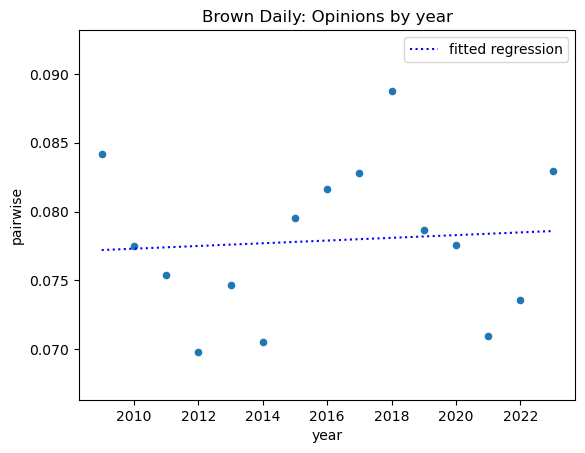

In [31]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Create a line plot of the data
results_df.plot(x="year", y="pairwise", kind="scatter")

# Add the linear regression line to the plot
plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Brown Daily: Opinions by year")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()


mentions-norm slope:0.02641, int:0.22985, r:0.57074, p:0.02629, se:0.01054, x:range(0, 15)
pairwise slope:0.00010, int:0.07721, r:0.07981, p:0.77738, se:0.00034, x:range(0, 15)
trace slope:0.00705, int:1.93959, r:0.55613, p:0.03133, se:0.00292, x:range(0, 15)
norm-1 slope:0.00219, int:2.07719, r:0.15202, p:0.58860, se:0.00394, x:range(0, 15)
norm-2 slope:0.00657, int:1.79411, r:0.51142, p:0.05135, se:0.00306, x:range(0, 15)
norm-inf slope:0.00219, int:2.07719, r:0.15202, p:0.58860, se:0.00394, x:range(0, 15)


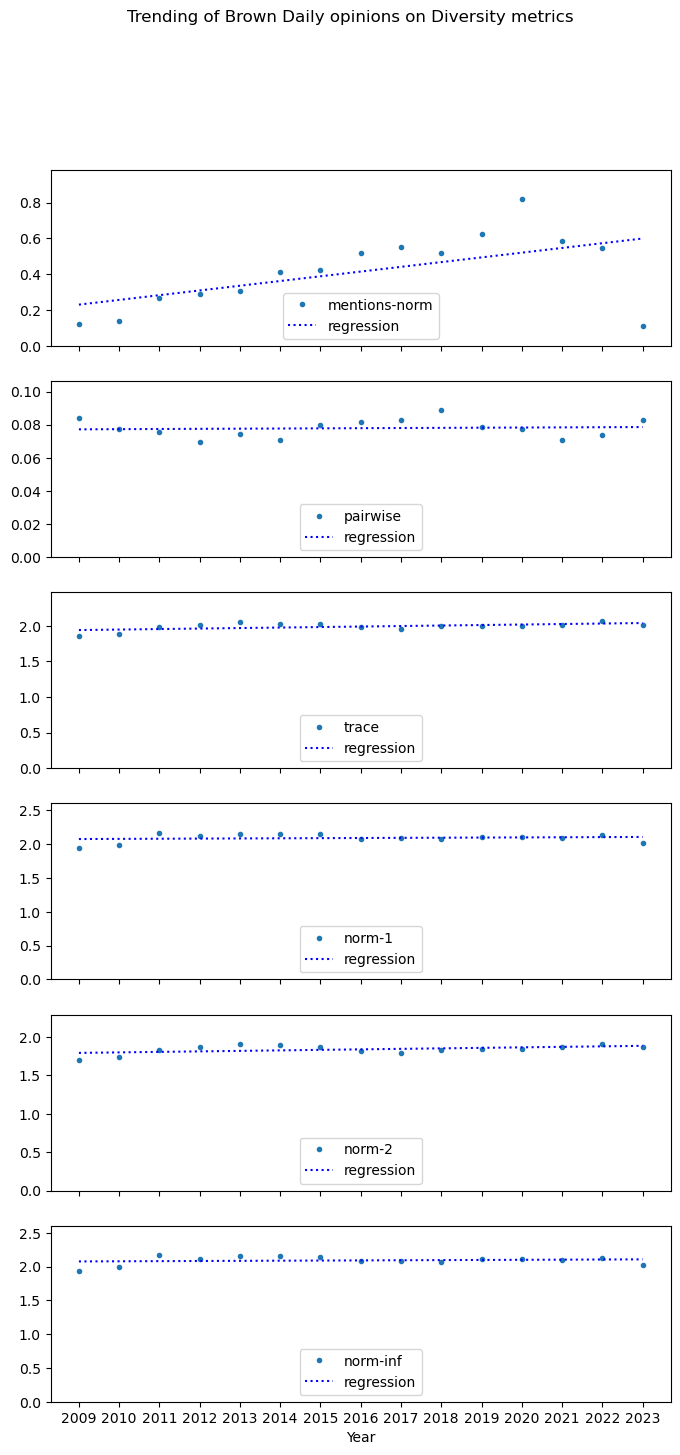

In [32]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise", "trace", "norm-1", "norm-2", "norm-inf"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=len(columns), ncols=1, sharex=True, figsize=(8,16))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)

    # Add a title
    # ax.set_title(f"Trending of {column} in Brown Daily")
    
plt.xlabel("Year")
plt.suptitle("Trending of Brown Daily opinions on Diversity metrics")
plt.show()

mentions-norm slope:0.02641, int:0.22985, r:0.57074, p:0.02629, se:0.01054, x:range(0, 15)
pairwise slope:0.00010, int:0.07721, r:0.07981, p:0.77738, se:0.00034, x:range(0, 15)


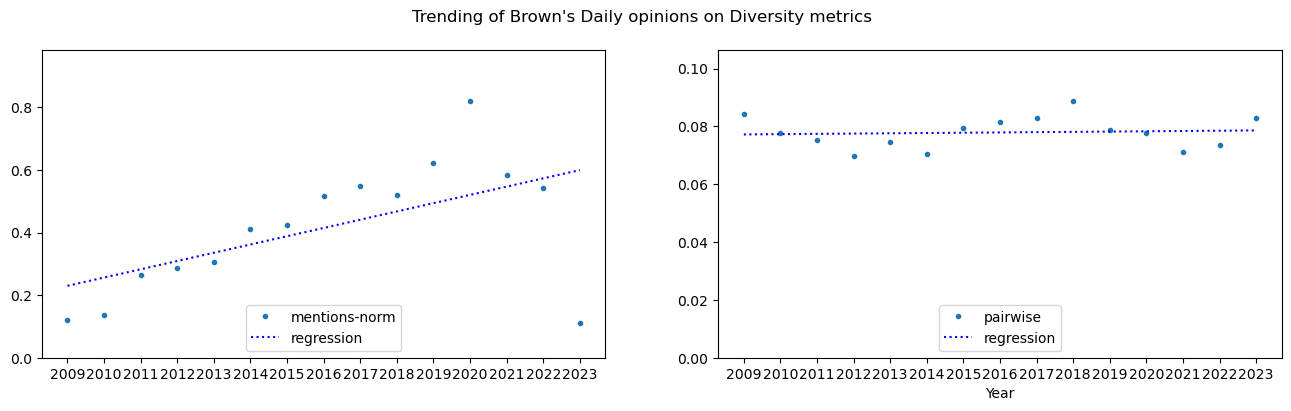

In [33]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16,4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)

    # Add a title
    # ax.set_title(f"Trending of {column} in Brown's Daily")
    
plt.xlabel("Year")
plt.suptitle("Trending of Brown's Daily opinions on Diversity metrics")
plt.show()